## Imports

Outside of scanpy, which is a python library for analyzing scRNAseq these rest of these should be standard computational python libraries

In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm

If you need to install scanpy here is a cell for that

In [2]:
#!pip install scanpy

In [3]:
import scanpy as sc

## Mann Whitney Test

To illustrate the speedup you can get from vectorization I we will talk about the MannWhitney test because the default function for doing this in python (`stats.mannwhitneyu`) is not vectorized. However, as long as you know the math behind the function it is pretty straightforward to code it up and get a big speedup.

The test is often used to find marker genes in scRNAseq data. This analysis is generally called Differential Expression (DE). By testing the differnetial expression for every gene between cell-types you can identify genes that identify the cell type. There are many ways to compute this. Parametrically this is usually done using a glm, but you can do it non-parametrically with a MannWhitney test.

Today we are using some sample data from scanpy that is scRNAseq of mouse bone marrow. 



In [4]:
paul = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


This data is stored as an AnnData object

<img src="https://falexwolf.de/img/scanpy/anndata.svg" />

For this analysis you just need the expression data and the cluster labels. The expression data is stored in cells x genes under `.X` and the clusters are stored in `.obs` as `paul15_clusters`

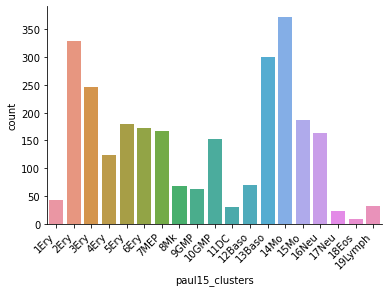

In [5]:
clusters = paul.obs.paul15_clusters
ax = sns.countplot(clusters)
ax.set_xticklabels(ax.get_xticklabels(),ha='right',rotation=45)
sns.despine()

Differential expression can be done by either comparing each cluster to all other clusters, known as 1vAll or done using a 1v1 approach, where you compute all pairwise comparisions between the clusters. 

For this exercise we can just select 2 clusters and compare them. I selected two Monocyte clusters, 14Mo and 15Mo but you can use any pair of clusters you want

In [6]:
##Getting the clusters you need
selected_clusters = clusters.isin(['14Mo', '15Mo'])

cluster_labels = clusters[selected_clusters]
cluster14 = cluster_labels.index[cluster_labels == '14Mo']
cluster15 = cluster_labels.index[cluster_labels == '15Mo']

In [7]:
##Subsetting the expression data (stored)
expression = paul.to_df()[selected_clusters]
expression.shape

(559, 3451)

To illustrate the speedup we get from vectorization we need to first compute differntial expression p values using `stats.mannwhitneyu` 

> Note: It is common for gene expression to be 0 for all cells for a given gene, which will throw an error in the `stats.mannwhitneyu`

In [10]:
%%timeit
pvals = pd.Series()
for gene in expression.columns:
    try:
        pvals[gene] = stats.mannwhitneyu(expression.loc[cluster14, gene],
                                         expression.loc[cluster15, gene])[1]
    except:
        pvals[gene] = 1

7.76 s ± 401 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Calculating Mann Whitney U test statistic:

There are a few equations you need for computing significance values for this. 

1. Compute U

$\large{U = R - ((n_1 * (n_1 + 1)) /2)}$

$n_1$ = sample size of group 1

$n_2$ = sample size of group 2

R is sum of the ranks of (order) of the values of group 1

2. Compute Z

$\large{Z = \frac{|U - \frac{n_1 * n_2}{2}|}{\sqrt{\frac{n_1 * n_2 * (n_1 + n_2 + 1)}{12}}}}$

Note the above equation doesn't use tie correction, which is lightly different than the `stats.mannwhitenyu` function. Ranks are computed by giving ties the average rank of all the values, which slightly messes up the standard deviation of the uniform distribution. This correction isn't totally necessary, and excluding it just makes your p values more conservative 

$\large{Z = \frac{U - \textit{m}_U}{\sigma_U}}$

$\large{\textit{m}_U = \frac{n_1n_2}{2}}$

$\large{\sigma_{corr} = \sqrt{\frac{n_1n_2}{12}((n+1) - \sum\limits_{i=1}^k{\frac{t_i^3 - t_i}{n(n-1)}})}}$

$n = n_1 + n_2$

$t_i$ is the number of subjects sharing rank i, and k is the number of (distinct) ranks

3. Use normal distribution to compute p values

In [73]:
R = expression.rank()
n1 = cluster14.shape[0]
n2 = cluster15.shape[0]

U = np.sum(R.loc[cluster14].values, axis=0) - ((n1 * (n1 + 1)) / 2)

Z = (U - ((n1 * n2) / 2)) / np.sqrt((n1 * n2 * (n1 + n2 + 1)) / 12)

p = stats.norm.sf(Z)

In [75]:
p

array([0.9991665 , 0.55777512, 0.29252189, ..., 0.43871702, 0.81050666,
       0.3390156 ])

These are uncorrected p values, which aren't terribly useful, so to correct them you can use the Benjamini Hotchberg procedure using `sm.stats.multipletests ` (in statsmodels)


In [76]:
padj = sm.stats.multipletests(p, method='fdr_bh')[1]

When doing differential expression it often isn't enough to just look at the p values to discern markers. So we often use a second metric, log2FoldChange. 


You calculate log2FC by subtracting the average expressions from each other for each gene. Then taking the log2 of the difference. While you can't compute the log of a negative, you need to store the sign of the difference and put it on the result of computing the log becasue this notes whether or not the gene is up or downregulated.

In [125]:
log2FC = np.log2(expression.loc[cluster14].mean(axis=0) /
                 expression.loc[cluster15].mean(axis=0))

/Users/bharris/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


If you want to visualize these results you can create what is known as a volcano plot, where you create a scatterplot with log2FoldChange on the x axis and -log10padj.

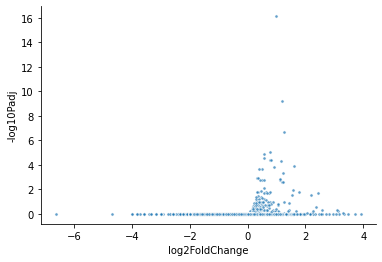

In [130]:
logpadj = -1 * np.log10(padj)
ax=sns.scatterplot(log2FC, logpadj, s=10, alpha=.7)
ax.set(xlabel='log2FoldChange', ylabel='-log10Padj')
sns.despine()
plt.show()